# r5py: Case Brighton - Calculate travel time matrices in Python

### Lesson objectives

This tutorial focuses on introducing you how to compute travel time matrices by different travel modes using a new Python library called `r5py` (still a work in progress). Travel time data is fundamental information whenever aiming to analyze e.g. accessibility -related questions.

### Library status

`r5py` is still very much a work in progress but it already has core functionalities available to compute travel time matrices that are relevant to spatial accessibility analysis. `r5py` is still missing many of the functionalities of `r5r`, but eventually, both of these libraries aim to provide a similar set of functionalities. 

### Run these codes in Binder

Before you can run this Notebook, and/or do any programming, you need to launch the Binder instance. You can find buttons for activating the python environment at the top-right of this page which look like this:

![Launch Binder](img/launch_binder.png)

### Working with Jupyter Notebooks

Jupyter Notebooks are documents that can be used and run inside the JupyterLab programming environment containing the computer code and rich text elements (such as text, figures, tables and links). 

**A couple of hints**:

- You can **execute a cell** by clicking a given cell that you want to run and pressing <kbd>Shift</kbd> + <kbd>Enter</kbd> (or by clicking the "Play" button on top)
- You can **change the cell-type** between `Markdown` (for writing text) and `Code` (for writing/executing code) from the dropdown menu above. 

See **further details and help for** [**using Notebooks and JupyterLab from here**](https://pythongis.org/part1/chapter-01/nb/04-using-jupyterlab.html). 



## Compute travel time matrices 

When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many). Next, we will learn how to calculate travel time matrices using `r5py` Python library. 

When calculating travel times with `r5py`, you typically need a couple of datasets:

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) format:
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit.
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g., by cropping the data or adding special costs for travelling (e.g., for considering slope when cycling/walking). When doing this, you should follow the instructions on the [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about the [GTFS standard here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5py` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing, e.g., the bus and metro connections.


### Sample datasets

In the following tutorial, we use open source datasets for Brighton & Hove:
- The point dataset for this tutorial has been obtained from [WorldPop -project](https://hub.worldpop.org/project/categories?id=3) licensed under a Creative Commons Attribution 4.0 International License.
- The street network is a cropped and filtered extract of OpenStreetMap (© OpenStreetMap contributors, [ODbL license](https://www.openstreetmap.org/copyright))
- The GTFS transport schedule dataset for Brighton are open datasets obtained from:
  - Bus schedules: [Brighton & Hove Bus and Coach Company](https://www.buses.co.uk/open-data) licensed under [Open Government License Version 3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

## Download the datasets

We have prepared a Zip-package with all relevant data that helps you to start working with the tools quickly. You can download and extract the data by executing the following commands:

In [25]:
# Download the data from a S3 bucket into 'data' folder
!wget -P data/ https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/R5edu/Brighton.zip
    
# Extract the contents
!unzip -q data/Brighton.zip -d data/

--2022-11-29 21:45:08--  https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/R5edu/Brighton.zip
Resolving a3s.fi (a3s.fi)... 86.50.254.19, 86.50.254.18
Connecting to a3s.fi (a3s.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68301274 (65M) [application/zip]
Saving to: ‘data/Brighton.zip’

Brighton.zip        100%[===================>]  65,14M  36,2MB/s    in 1,8s    

2022-11-29 21:45:10 (36,2 MB/s) - ‘data/Brighton.zip’ saved [68301274/68301274]



If running the cell above does not work for some reason (on your local computer), you can [manually download the data](https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/R5edu/Brighton.zip). If you do this, extract the contents of the Zip file (`Brighton.zip`) into the `<YOUR_FOLDER_CONTAINING_THIS_NOTEBOOK>/data` -folder. 

### Load the origin and destination data

Let's start by downloading a sample point dataset into a geopandas `GeoDataFrame` that we can use as our origin and destination locations. For the sake of this exercise, we have prepared a grid of points covering parts of Sussex. The point data also contains the number of residents of each 100 meter cell:

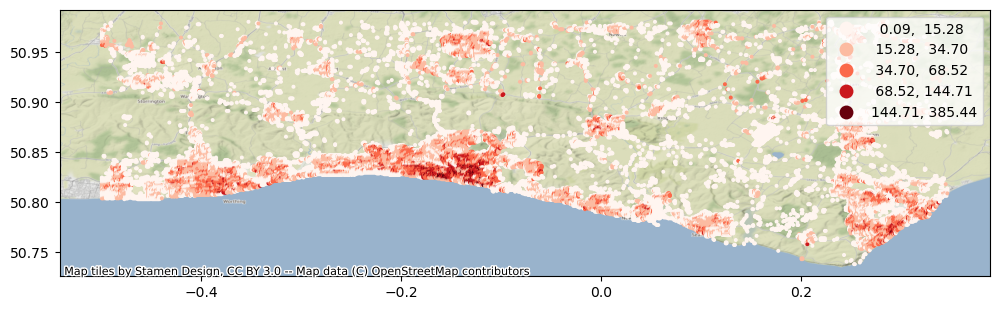

In [26]:
import geopandas as gpd
import contextily as cx

# Load population points
pop_fp = "data/Brighton/Brighton_pop_points_2020.gpkg"
pop_points = gpd.read_file(pop_fp)

ax = pop_points.plot("population", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=pop_points.crs)

Let's also check how the attribute table of the data looks like:

In [2]:
# Check the first 5 rows
pop_points.head()

x          y  population  id                   geometry
0 -0.499167  50.972500   10.112679   0  POINT (-0.49917 50.97250)
1 -0.499167  50.971667   19.579712   1  POINT (-0.49917 50.97167)
2 -0.499167  50.970833   12.178864   2  POINT (-0.49917 50.97083)
3 -0.499167  50.968333    5.552000   3  POINT (-0.49917 50.96833)
4 -0.499167  50.967500    2.551825   4  POINT (-0.49917 50.96750)

Next, we will geocode the address for Brighton Railway station. For doing this, we can use `oxmnx` library and its handy `.geocode()` -function:

In [3]:
import osmnx as ox
from shapely.geometry import Point

# Find coordinates of the main railway station 
lat, lon = ox.geocode("Railway station, Brighton")

# Create a GeoDataFrame out of the coordinates
station = gpd.GeoDataFrame({"geometry": [Point(lon, lat)], "name": "Brighton Railway station", "id": [0]}, index=[0], crs="epsg:4326")
station.explore(max_zoom=14, color="red", marker_kwds={"radius": 12})

- Next, we will prepare the routable network

In [4]:
%%time
# Allow 6 GB memory
import sys
sys.argv.append(["--max-memory", "6G"])

import datetime
from r5py import TransportNetwork, TravelTimeMatrixComputer, TransitMode, LegMode

# Filepath to OSM data
osm_fp = "data/Brighton/brightonhove.pbf"

transport_network = TransportNetwork(
    osm_fp,
    [
        "data/Brighton/brightonhove_1667288932.zip"
    ]
)


CPU times: user 1min 24s, sys: 2.15 s, total: 1min 26s
Wall time: 29.4 s


- After this step, we can do the routing

In [5]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=station,
    destinations=pop_points,
    departure=datetime.datetime(2022,12,1,7,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

Running in non-interactive shell, SIGINT handler is replaced by shell
Signal Handlers:
SIGSEGV: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGBUS: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGFPE: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGPIPE: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGXFSZ: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGILL: [libjvm.so+0xc2d970], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGUSR2: [libjvm.so+0xc2dc60], sa_mask[0]=00000000000000000000000000000000, sa_flags=SA_RESTART|SA_SIGINFO
SIGHUP: [libjvm.so+0xc2ddc0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGINT: SIG_IGN, sa_mask[0]=00000000000000000000000000000000,

- Now we can join the travel time information back to the population grid

In [6]:
geo = pop_points.merge(travel_time_matrix, left_on="id", right_on="to_id")

- Finally, we can visualize the travel time map and investigate how the railway station in Brighton can be accessed from different parts of the region, by public transport.

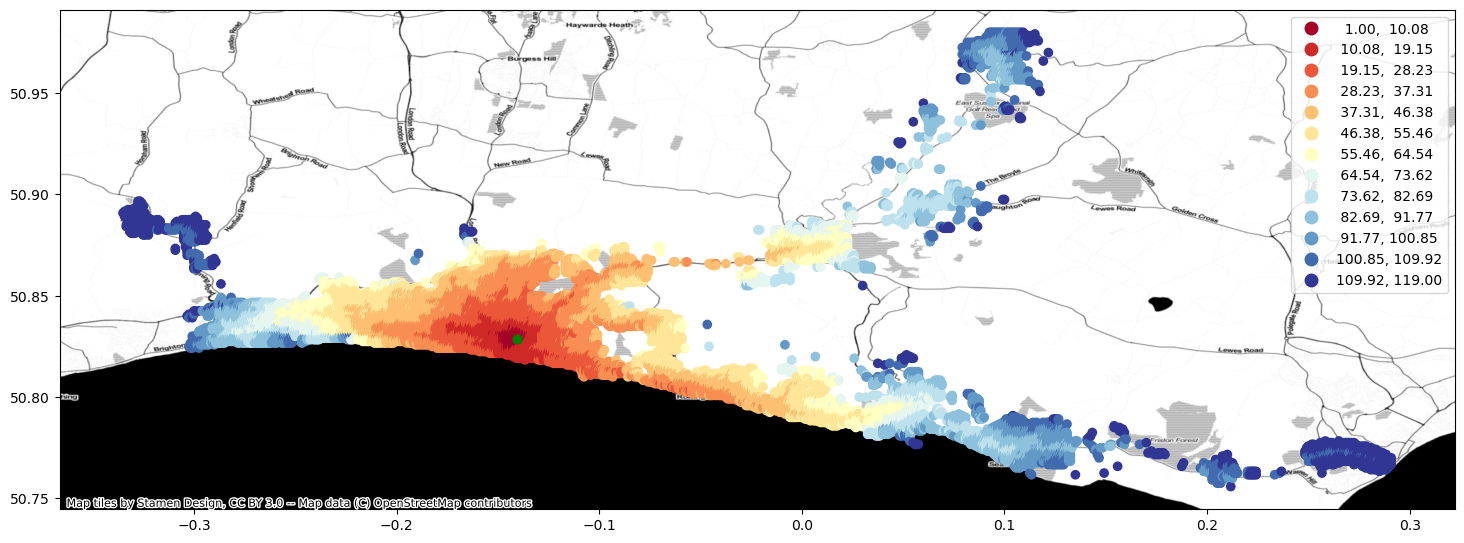

In [7]:
import contextily as cx
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

## Calculate travel times by bike

In a very similar manner, we can calculate travel times by cycling. We only need to modify our `TravelTimeMatrixComputer` object a little bit. We specify the cycling speed by using the parameter `speed_cycling` and we change the `transport_modes` parameter to correspond to `[LegMode.BICYCLE`. This will initialize the object for cycling analyses:

In [8]:
tc_bike = TravelTimeMatrixComputer(
    transport_network,
    origins=station,
    destinations=pop_points,
    speed_cycling=16,
    transport_modes=[LegMode.BICYCLE],
)
ttm_bike = tc_bike.compute_travel_times()

- Let's again make a table join with the population grid

In [9]:
geo = pop_points.merge(ttm_bike, left_on="id", right_on="to_id")

- And plot the data

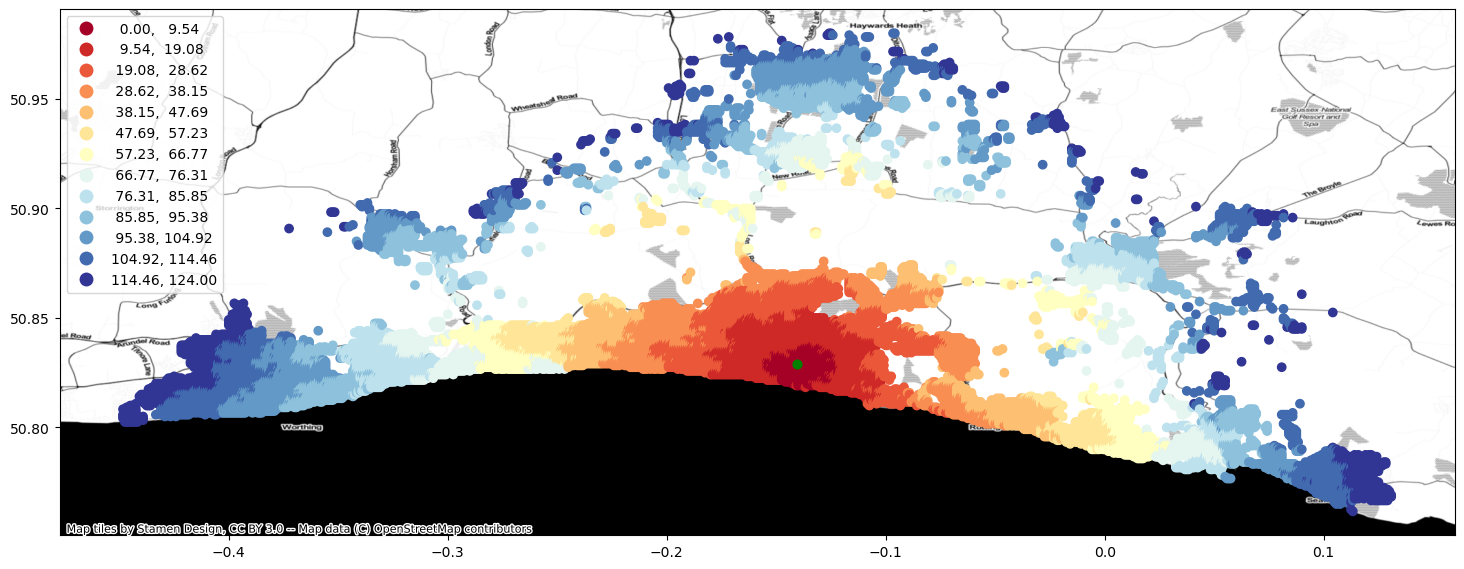

In [10]:
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

## Calculate catchment areas

One quite typical accessibility analysis is to find out catchment areas for multiple locations, such as schools. In the below, we will extract all schools in Brighton area and calculate travel times from all grid cells to the closest one. As a result, we have catchment areas for each school.

Let's start by preparing data. In the following, we will:

- Download OSM data about locations of schools in Brighton area, using `osmnx`. 
- Some of the downloaded geometries might be in Polygon format, so we need to convert them into points by calculating their centroid
- We will also add a column `id` for the data which is required by `r5py` (as well as `r5r`)

In [11]:
import osmnx as ox
from shapely.geometry import box

# Extent of the data for Brighton
# (minx, miny, maxx, maxy)
bounds = (-0.49975, 50.73,  0.3469234, 50.98)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[box(*bounds)], crs="EPSG:4326")
gdf.explore()

# Download schools from OpenStreetMap
tags = {"amenity": "school"}
schools = ox.geometries_from_polygon(gdf.geometry.values[0], tags)

# Use centroid as geometry (we ignore the shape of the building)
schools["geometry"] = schools.centroid

# Add a unique id column based on the index
schools["id"] = schools.index.droplevel(level=0)

# Plot to map
schools.explore()

/tmp/ipykernel_535156/1593569817.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schools["geometry"] = schools.centroid


- Next, we can initialize our travel time matrix calculator using the schools as the origins:

In [12]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=schools,
    destinations=pop_points,
    departure=datetime.datetime(2022,12,1,8,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

In [13]:
travel_time_matrix.shape

(13250240, 3)

- As we can see, there are approx. 1.3 million rows of data, which comes as a result of the connections between origins and destinations. Next, we want aggregate the data and keep only travel time information to the closest school: 

In [14]:
# Find out the travel time to closest school
closest = travel_time_matrix.groupby("to_id")["travel_time"].min().reset_index()

In [15]:
closest.head()

to_id  travel_time
0      0         42.0
1      1         39.0
2      2         40.0
3      3         41.0
4      4         42.0

Then we can make a table join with the grid in a similar manner as previously and visualize the data:

In [16]:
geo = pop_points.merge(closest, left_on="id", right_on="to_id")

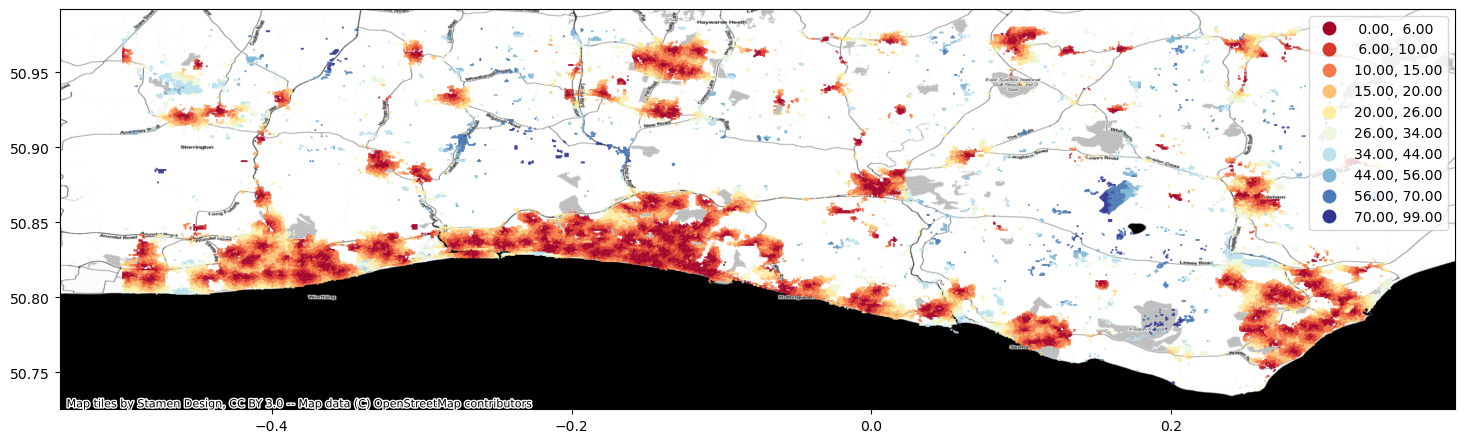

In [17]:
import contextily as cx
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="natural_breaks", k=10, legend=True, figsize=(18,18), markersize=0.2)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

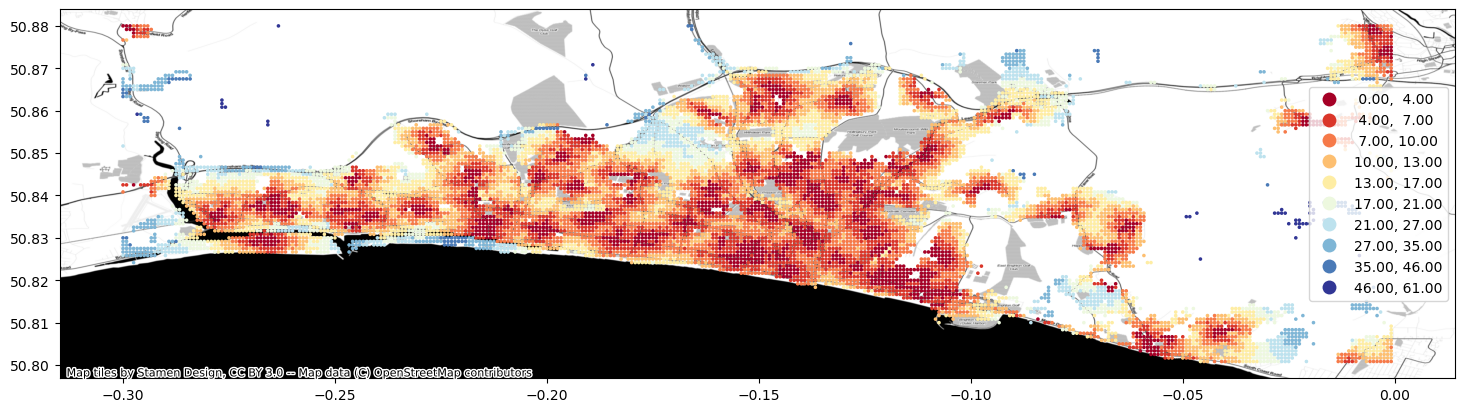

In [18]:
# Make a zoom-in map - .cx is used to limit the data based on minx: maxx, miny: maxy
ax = geo.cx[-0.3: 0, 50.8: 50.88].plot(column="travel_time", cmap="RdYlBu", scheme="natural_breaks", k=10, legend=True, figsize=(18,18), markersize=2.5)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

In [19]:
# Make an interactive map - .cx is used to limit the data based on minx: maxx, miny: maxy
# Note: Be careful not to plot a large area of points, because the interactive plotting uses a lot of memory
geo.cx[-0.2: -0.1, 50.8: 50.88].explore(column="travel_time", cmap="RdYlBu", 
                                        scheme="natural_breaks", k=10, legend=True, 
                                        marker_kwds={"radius": 2.5})

That's it! As you can, see now we have a nice map showing the catchment areas for each school.